In [245]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth
from isca_tools.utils.constants import epsilon, L_v, c_p
from isca_tools.utils.moist_physics import saturation_vapor_pressure, clausius_clapeyron_factor, sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [277]:
%%time
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

CPU times: user 80 µs, sys: 524 µs, total: 604 µs
Wall time: 756 µs


In [12]:
def time_to_year(ds):
    ds = ds.assign_coords(year=ds['time'].dt.year)  # Add a 'year' coordinate
    ds = ds.swap_dims({'time': 'year'})             # Replace 'time' as dimension with 'year'
    ds = ds.drop_vars('time')                       # Optionally remove 'time' variable
    return ds

## Sanity Check that my data is similar to Zhang and Boos
Below we see that except for 2021 for `t2m`, and 1999 and 2021 for `t500` the values I got from ERA5 and that used by Zhang in the 2023 paper are very similar.

I guess the 2021 data may have been updated since Zhang did their analysis. For 1999, it seems there are some land areas around the tropics which are larger in my data compared to Zhang. But it seems that my plot of `t500_of_t2m_max` is much better than the Zhang plot.

In [168]:
t2m_av_use = 'max'     # get variables conditioned on annual maximum of daily max or mean temperature
# Should only match zhang and boos if 'max' used

In [169]:
t2m_max_zhang = time_to_year(xr.open_dataset('./Code_Zhang_Boos/TXx_1979-2021.nc')).TXx
t2m_max = xr.open_dataset(f'./processed/daily_{t2m_av_use}/t2m_max.nc').t2m

In [170]:
t500_zhang = time_to_year(xr.open_dataset('./Code_Zhang_Boos/t500ofTXx_1979-2021.nc')).t500
t500 = xr.open_dataset(f'./processed/daily_{t2m_av_use}/t500_of_t2m_max.nc').isel(pressure_level=0, drop=True).t500
t500 = t500.drop('number')

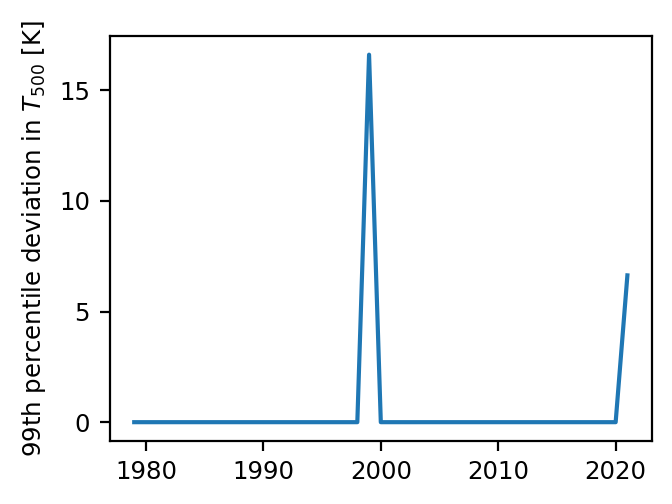

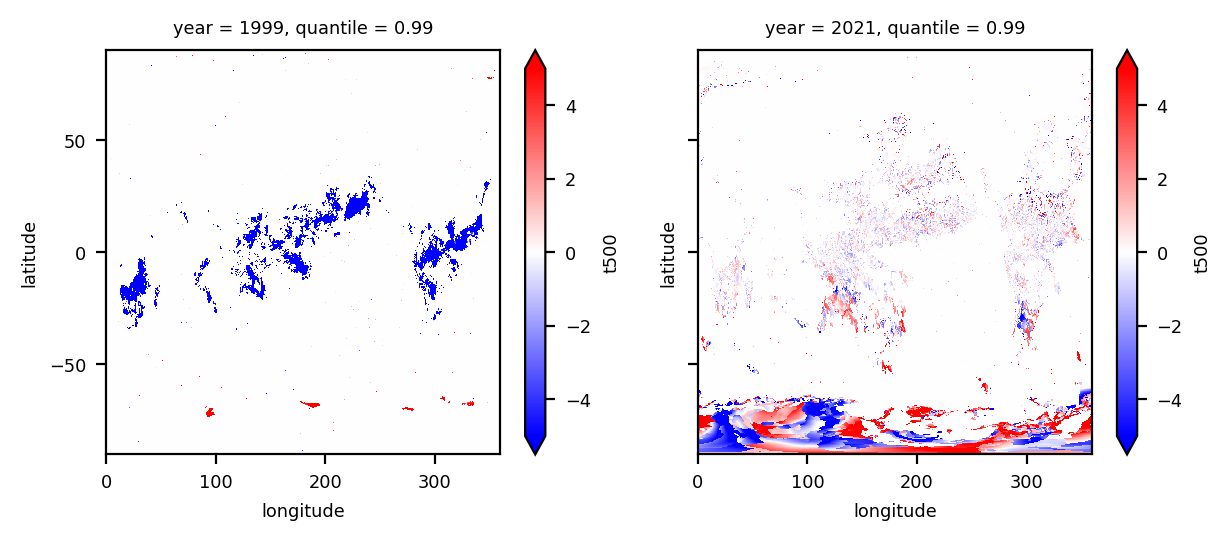

In [173]:
var_plot = 't500'
if var_plot == 't2m':
    var_diff = (t2m_max_zhang - t2m_max)
else:
    var_diff = (t500_zhang - t500)
var_diff_abs_max = np.abs(var_diff).quantile(0.99, dim=['longitude', 'latitude'])
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3.5)
ax.plot(var_diff.year, var_diff_abs_max)
ax.set_ylabel(f'99th percentile deviation in $T_{"{2m}" if var_plot=="t2m" else "{500}"}$ [K]')
update_fontsize(fig)

# Plot years with large deviation
years_plot = var_diff_abs_max > 1
n_plot = int(sum(years_plot))
if n_plot > 3:
    n_plot = 3
fig, ax = plt.subplots(1, n_plot, sharex=True, sharey=True)
if n_plot == 1:
    ax = [ax]
fig_resize(fig, 3.5*n_plot)
for i, year in enumerate(var_diff.year[years_plot]):
    var_diff.sel(year=year).plot(ax=ax[i], vmin=-5, vmax=5, cmap='bwr')
    if i >= n_plot - 1:
        break

update_fontsize(fig)
plt.show()

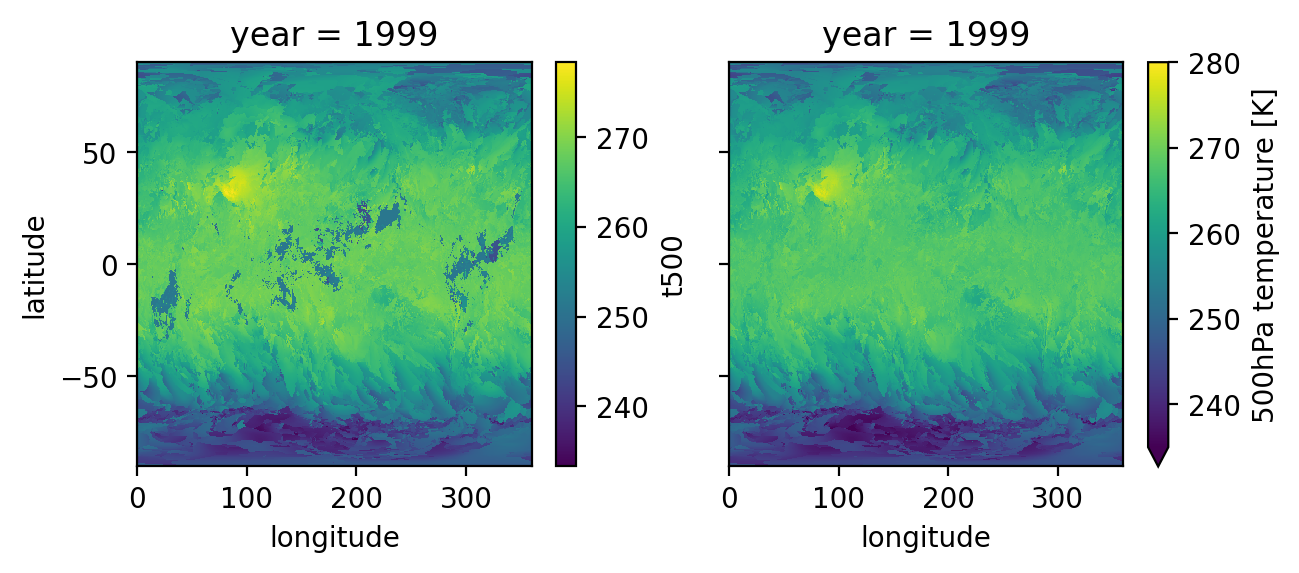

In [243]:
year = 1999
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 3.5*2)
t500_zhang.sel(year=year).plot(ax=ax[0])
t500.sel(year=year).plot(ax=ax[1], vmin=235, vmax=280)
ax[1].set_ylabel('')
plt.show()

In [175]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
lsm_zhang = xr.open_dataset('./Code_Zhang_Boos/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc').LSM.squeeze()
lsm = xr.open_dataset('../invariants/lsm1979.nc').lsm.squeeze()
# lsm = lsm_zhang
land = lsm.where(lsm>0.5)*0+1
ocean = lsm.where(lsm<=0.5)*0+1
weights = np.cos(np.deg2rad(land.latitude))

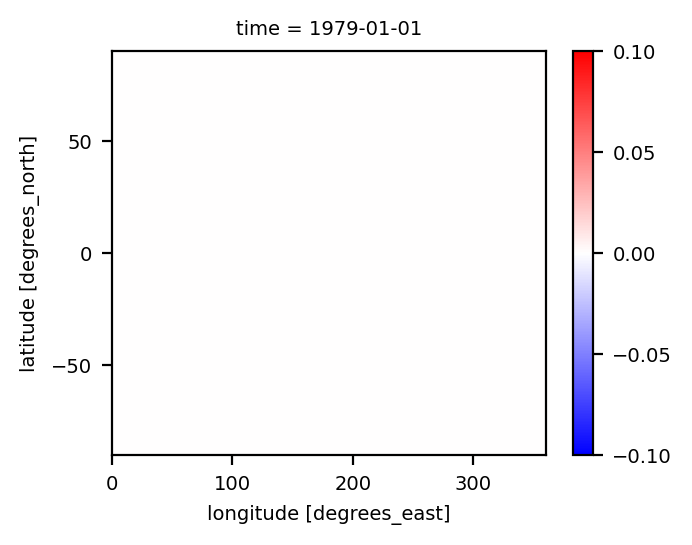

In [176]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3.5)
(lsm_zhang - lsm).plot(vmin=-0.1, vmax=0.1, cmap='bwr', ax=ax)
update_fontsize(fig)
plt.show()

### Figure 4 of Zhang & Boos

In [274]:
def xr_linregress(x, y, dim="time"):
    # align the nan Values before...
    x = x.where(~np.isnan(y))
    y = y.where(~np.isnan(x))
    n = y.notnull().sum(dim)

    nanmask = np.isnan(y).all(dim)

    xmean = x.mean(dim)
    ymean = y.mean(dim)
    xstd = x.std(dim)
    ystd = y.std(dim)

    cov = ((x - xmean) * (y - ymean)).sum(dim) / (n)
    cor = cov / (xstd * ystd)

    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope

    df = n - 2
    TINY = 1.0e-20
    tstats = cor * np.sqrt(df / ((1.0 - cor + TINY) * (1.0 + cor + TINY)))
    stderr = slope / tstats

    pval = (
        xr.apply_ufunc(
            sts.distributions.t.sf,
            abs(tstats),
            df,
            dask="parallelized",
            output_dtypes=[y.dtype],
        )
        * 2
    )

    return xr.Dataset(
        {
            "slope": slope,
            "intercept": intercept,
            "r_value": cor.fillna(0).where(~nanmask),
            "p_value": pval,
            "std_err": stderr.where(~np.isinf(stderr), 0),
        }
    )

z500_mean = 55.74162890625 * 1000   # 5 km x 9.81 would be 55 so the zhang value of 55 must be in units of km multiplied by g
t500_mean = 258.82523

def dT2m_dT500_theory(T500):
    # Prefactor to multiply by change in T_500 to get estimate of change in 2m temperature
    p500 = 500 * 100       # 500 hPa in Pa
    return 1 + L_v/c_p * clausius_clapeyron_factor(T500, p500) * sphum_sat(T500, p500)+z500_mean/t500_mean/c_p

In [279]:
%%time
# TXx from ERA5 reanlysis
TXx = t2m_max
if 'year' in TXx.coords:
    TXx = TXx.rename({'year': 'time'})
    TXx = TXx.assign_coords(time=pd.date_range(start='1979-01-01', end='2021-01-01', freq='AS'))
TXx_mean =  (TXx*land).sel(latitude=slice(65,40)).weighted(weights).mean(['latitude','longitude'])

# T500 on the annual hottest days from ERA5 reanalysis
t500_of_TXx = t500 # Refer to the other notebook for these data were generated
if 'year' in t500_of_TXx.coords:
    t500_of_TXx = t500_of_TXx.rename({'year': 'time'})
    t500_of_TXx = t500_of_TXx.assign_coords(time=pd.date_range(start='1979-01-01', end='2021-01-01', freq='AS'))
t500_of_TXx_mean = (t500_of_TXx*land).sel(latitude=slice(65,40)).weighted(weights).mean(['latitude','longitude'])
t500_trend = sts.linregress(np.arange(1979,2022), t500_of_TXx_mean).slope
t500_trend_std = sts.linregress(np.arange(1979,2022), t500_of_TXx_mean).stderr

# Calculated land-mean TXx trend from T500 trend
TXx_trend_proj = t500_trend*dT2m_dT500_theory(t500_of_TXx_mean.mean())
TXx_trend_proj_std = t500_trend_std*dT2m_dT500_theory(t500_of_TXx_mean.mean())

#
#
# # 2-D plots
time = xr.DataArray(data = np.arange(1979, 2022), coords={'time': TXx.time}, dims='time')
reg_TXx = xr_linregress(time.sel(time=slice('1979','2021')), (TXx*land).sel(time=slice('1979','2021'))).compute() # Linear trend of TXx for each location over land
reg_t500_of_TXx = xr_linregress(time.sel(time=slice('1979','2021')), (t500_of_TXx*land).sel(time=slice('1979','2021'))).compute() # T500 trend for each location over land
reg_TXx_proj = reg_t500_of_TXx*dT2m_dT500_theory(t500_of_TXx.mean('time')) # Calculated TXx trend from theory and T500 trend

CPU times: user 2.85 s, sys: 1.49 s, total: 4.35 s
Wall time: 5.16 s


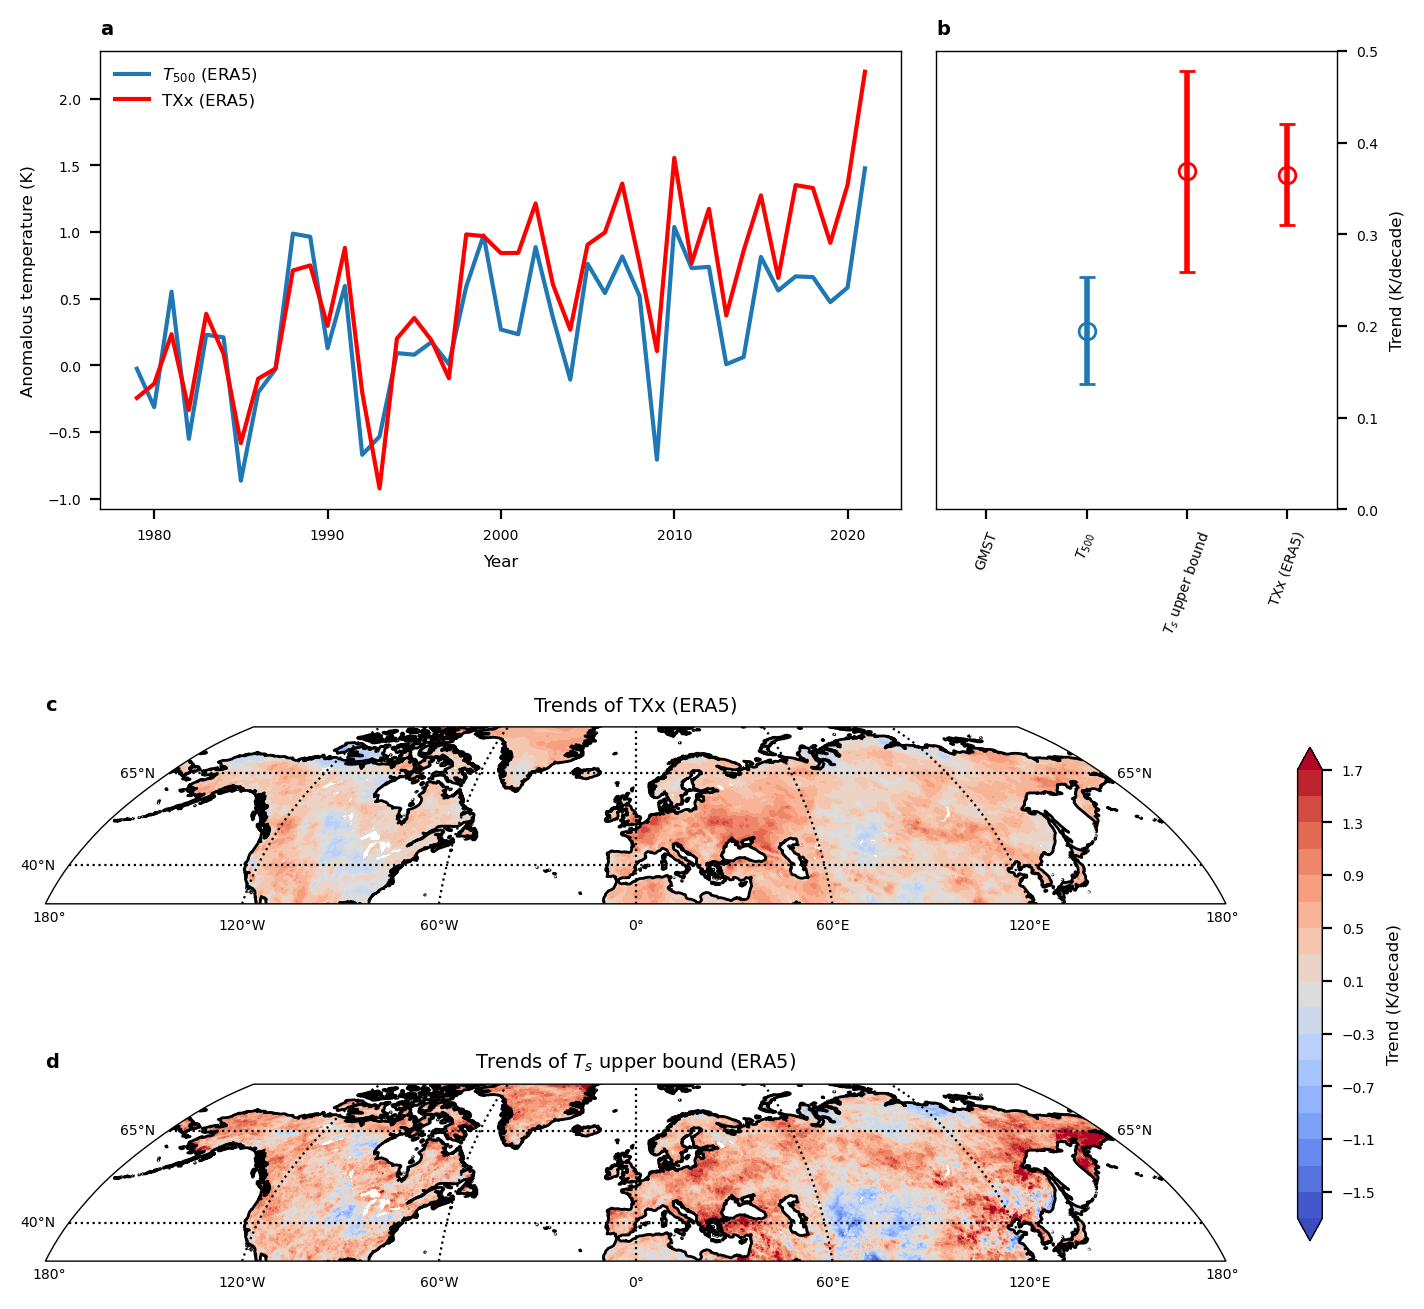

CPU times: user 49 s, sys: 672 ms, total: 49.6 s
Wall time: 50.4 s


In [280]:
%%time
fig = plt.figure(constrained_layout=True,figsize=(7.,6.5))
subfigs = fig.subfigures(2,1,height_ratios=(1,1.), hspace=0.05)

subfig0 = subfigs[0].subplots(1,2, gridspec_kw = {'width_ratios': (2,1), 'wspace': 0.05})
subfig1 = subfigs[1].subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0.15})
ax0 = subfig0[0]
ax1 = subfig0[1]
ax3 = subfig1[0]
ax4 = subfig1[1]
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")


# ax0.plot(np.arange(1979,2022), gmst[1979-1850:2022-1850]-gmst[1979-1850:1979-1850+10].mean(), c='grey', label='GMST (HadCRUT5)')
ax0.plot(np.arange(1979,2022), t500_of_TXx_mean-t500_of_TXx_mean[0:10].mean(), c='C0', label='$T_{\mathrm{500}}$ (ERA5)')
ax0.plot(np.arange(1979,2022), TXx_mean-TXx_mean[0:10].mean(), c='r', label='TXx (ERA5)')
# ax0.plot(np.arange(1979,2019), TXx_ex-TXx_ex[0:10].mean(), c='r', ls='--', label='TXx (HadEX3)')
ax0.legend(frameon=0)
ax0.set_xlabel('Year')
ax0.set_ylabel('Anomalous temperature (K)')
ax0.set_title('a', weight='bold', loc='left')

# obj = sts.linregress(np.arange(1979,2022), gmst.sel(time=slice('1979','2021')))
# slope_gmst = obj.slope
# std_gmst = obj.stderr
# ax1.errorbar(-1, obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='grey', lw=2)
obj = sts.linregress(np.arange(1979,2022), t500_of_TXx_mean.sel(time=slice('1979','2021')))
ax1.errorbar(0, obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='C0', lw=2)
# ax1.text(-0.05, 0.1, "{:.1f}".format(obj.slope/slope_gmst))
ax1.errorbar(1, TXx_trend_proj*10, yerr=TXx_trend_proj_std*10, marker='o', mfc='None', capsize=3, color='r', lw=2)
# ax1.text(0.95, 0.22, "{:.1f}".format(TXx_trend_proj.values/slope_gmst))
obj = sts.linregress(np.arange(1979,2022), TXx_mean.sel(time=slice('1979','2021')))
ax1.errorbar(2,obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='r', lw=2)
# ax1.text(1.95, 0.26, "{:.1f}".format(obj.slope/slope_gmst))
ax1.set_xlim(-1.5,2.5)
ax1.set_xticks([-1, 0,1,2])
ax1.set_xticklabels(['GMST', '$T_{\mathrm{500}}$','$T_s$ upper bound','TXx (ERA5)'],rotation=70)
ax1.set_ylabel('Trend (K/decade)')
ax1.set_title('b', weight='bold', loc='left')
ax1.set_ylim([0, 0.5])


ax3.coastlines(color='k', linewidth=1)
ax3.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
ax3.set_title('c', weight='bold', loc='left')
gl = ax3.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                  ylocs=np.arange(40, 70, 25), linestyle=':',
                  color='k', alpha=1, draw_labels=True)
gl.right_labels =0
gl.top_labels=0
ax3.set_title('Trends of TXx (ERA5)')
data, lon = add_cyclic_point(reg_TXx.slope*10, coord=reg_TXx.longitude.values, axis=1)
im = ax3.contourf(lon, reg_TXx.latitude.values, data, transform=ccrs.PlateCarree(),levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')


ax4.coastlines(color='k', linewidth=1)
ax4.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
ax4.set_title('d', weight='bold', loc='left')
gl = ax4.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                  ylocs=np.arange(40, 70, 25), linestyle=':',
                  color='k', alpha=1, draw_labels=True)
gl.right_labels =0
gl.top_labels=0
data, lon = add_cyclic_point(reg_TXx_proj.slope*10, coord=reg_TXx_proj.longitude.values, axis=1)
im = ax4.contourf(lon, reg_TXx_proj.latitude.values, data, transform=ccrs.PlateCarree(),levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')



ax4.set_title('Trends of $T_s$ upper bound (ERA5)')
subfigs[1].colorbar(shrink=0.8, ax=subfig1, label='Trend (K/decade)', mappable=im)
plt.show()
# plt.savefig('./Fig4.pdf')